In [ ]:
# # Decoder-Only Transformer — Full Trace Visualization Notebook
# 
# This notebook:
# - loads the **latest decoder-only** run from `traces/`
# - picks a **long** example for clear visuals
# - trims pads so heatmaps aren’t mostly empty
# - shows attention **across layers** (avg over heads)
# - shows a **heads grid** at a chosen layer
# - makes an **animation** of attention across layers (inline JS; GIF saved if Pillow is available)
# - inspects **Q/K/V** (norms per position across layers, cosine(Q,K) map)
# - optionally visualizes **hidden-state** evolution (PCA), if captured

from pathlib import Path
import json, os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

from src.traces.store import TraceStore

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 10

OUT_DIR = Path("notebooks_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

#Load latest DECODER-ONLY run 
runs = sorted([p for p in Path("traces").iterdir() if p.is_dir()],
              key=lambda p: p.stat().st_mtime, reverse=True)

run_dir = None
for p in runs:
    try:
        meta = json.load(open(p/"meta.json","r",encoding="utf-8"))
        if meta.get("arch") == "dec":
            run_dir = str(p)
            break
    except Exception:
        pass

assert run_dir is not None, "No decoder-only run found in traces/. Extract GPT-2 first."

st = TraceStore(run_dir)
print("Loaded run:", run_dir)
print("Arrays:", st.arrays())
print("Meta model:", st.meta.get("model"))
print("Meta arch:", st.meta.get("arch"))

#Pick a long example for clearer plots
lens = st.tokens["attention_mask"].apply(lambda m: int(np.array(m, bool).sum()))
idx_long = int(lens.values.argmax())
eid = st.tokens.iloc[idx_long]["example_id"]
enc = st.encodings(eid)

text = st.text(eid)
tokens = enc.get("dec_tokens") or enc.get("tokens")
attn_mask = np.array(enc.get("dec_attention_mask") or enc.get("attention_mask"), dtype=bool)

print("example_id:", eid)
print("non-pad length:", int(attn_mask.sum()))
print("text:", (text[:300] + ("..." if len(text) > 300 else "")))
print("first 40 tokens:", tokens[:40])


# Effective layer/head counts from stored arrays + index maps
arrs = st.arrays()

# Decoder self-attention key
dec_attn_key = None
for k in ["dec_self_attn", "dec_attn", "attn"]:
    if k in arrs:
        dec_attn_key = k
        break
assert dec_attn_key is not None, f"No decoder self-attn array found. Arrays available: {list(arrs.keys())}"

# Shape: (N, L_eff, H_eff, Tq, Tk)
N_eff, L_eff, H_eff, _, _ = arrs[dec_attn_key]

meta = st.meta
# Attempt to recover original ids if extractor stored them; else fall back to local indices
layer_ids_dec = meta.get("layers_dec_indices") or meta.get("layers_dec") or list(range(L_eff))
head_ids_dec  = meta.get("heads_dec_indices")  or meta.get("heads_dec")  or list(range(H_eff))

if len(layer_ids_dec) != L_eff:
    warnings.warn(f"layers_dec index map length {len(layer_ids_dec)} != stored L {L_eff}; using local 0..{L_eff-1}")
    layer_ids_dec = list(range(L_eff))
if len(head_ids_dec) != H_eff:
    warnings.warn(f"heads_dec index map length {len(head_ids_dec)} != stored H {H_eff}; using local 0..{H_eff-1}")
    head_ids_dec = list(range(H_eff))

def dec_layer_local2actual(i): return layer_ids_dec[i] if isinstance(layer_ids_dec, (list,tuple)) else i
def dec_head_local2actual(i):  return head_ids_dec[i]  if isinstance(head_ids_dec,  (list,tuple)) else i

L = L_eff  # local count used for indexing arrays
H = H_eff

print(f"Stored decoder self-attn shape: L={L}, H={H}")
print("Layer ids (actual):", layer_ids_dec)
print("Head  ids (actual):", head_ids_dec)


Loaded run: traces\20251006-233929_gpt2_ud_ewt_validation_n16
Arrays: {'dec_self_attn': (16, 12, 12, 128, 128), 'dec_self_q': (16, 12, 12, 128, 64), 'dec_self_k': (16, 12, 12, 128, 64), 'dec_self_v': (16, 12, 12, 128, 64), 'dec_hidden': (16, 13, 128, 768)}
Meta model: gpt2
Meta arch: dec
example_id: 2381d9876142e5d6
non-pad length: 39
text: It seems clear to me that the manhunt for high Baath officials in the Sunni heartland is being done wrong, or at least in ways that are bad for US standing with local Iraqis.
first 40 tokens: ['<|endoftext|>' '<|endoftext|>' '<|endoftext|>' '<|endoftext|>'
 '<|endoftext|>' '<|endoftext|>' '<|endoftext|>' '<|endoftext|>'
 '<|endoftext|>' '<|endoftext|>' '<|endoftext|>' '<|endoftext|>'
 '<|endoftext|>' '<|endoftext|>' '<|endoftext|>' '<|endoftext|>'
 '<|endoftext|>' '<|endoftext|>' '<|endoftext|>' '<|endoftext|>'
 '<|endoftext|>' '<|endoftext|>' '<|endoftext|>' '<|endoftext|>'
 '<|endoftext|>' '<|endoftext|>' '<|endoftext|>' '<|endoftext|>'
 '<|endoft

In [ ]:
def _pick(enc, keys):
    for k in keys:
        if k in enc and enc[k] is not None:
            return enc[k]
    return None

def _bool(arr):
    a = np.asarray(arr)
    # handle lists of ints/bools already fine
    return a.astype(bool)

def trimmed_indices(enc, side="dec"):
    """
    Return index arrays for non-pad positions for queries and keys.
    For decoder self-attn: both come from decoder mask.
    For cross-attn (enc-dec): queries from dec mask, keys from enc mask.
    """
    if side == "dec":
        m_dec = _pick(enc, ["dec_attention_mask", "attention_mask"])
        idx_q = np.flatnonzero(_bool(m_dec))
        idx_k = idx_q
    elif side == "cross":
        m_dec = _pick(enc, ["dec_attention_mask", "attention_mask"])
        m_enc = _pick(enc, ["attention_mask", "dec_attention_mask"])
        idx_q = np.flatnonzero(_bool(m_dec))
        idx_k = np.flatnonzero(_bool(m_enc))
    else:
        # encoder-only case if ever used here
        m_enc = _pick(enc, ["attention_mask"])
        idx_q = idx_k = np.flatnonzero(_bool(m_enc))
    return idx_q, idx_k

def tok_clean(toks):
    return [t.replace("Ġ","▁") for t in toks]

def fetch_attn_trim(st, eid, *, layer, head, kind="self"):
    """
    kind: "self" (decoder self-attn) or "cross" (enc-dec).
    Returns (A_trim, q_tokens, k_tokens) trimmed to non-pad positions.
    """
    enc = st.encodings(eid)
    if kind == "self":
        A = st.attn(eid, side="dec", kind="self", layer=layer, head=head)
        idx_q, idx_k = trimmed_indices(enc, side="dec")
        toks = _pick(enc, ["dec_tokens", "tokens"])
        qtok = [toks[i] for i in idx_q]
        ktok = [toks[i] for i in idx_k]
        A = A[np.ix_(idx_q, idx_k)]
        return A, qtok, ktok
    elif kind == "cross":
        A = st.attn(eid, side="dec", kind="cross", layer=layer, head=head)
        idx_q, idx_k = trimmed_indices(enc, side="cross")
        toks_q = _pick(enc, ["dec_tokens", "tokens"])
        toks_k = _pick(enc, ["tokens", "dec_tokens"])
        qtok = [toks_q[i] for i in idx_q]
        ktok = [toks_k[i] for i in idx_k]
        A = A[np.ix_(idx_q, idx_k)]
        return A, qtok, ktok
    else:
        raise ValueError("kind must be 'self' or 'cross'")

def fetch_qkv_trim(st, eid, *, layer, head):
    """
    Return (Q,K,V) for decoder self-attn, trimmed to non-pad decoder positions.
    """
    enc = st.encodings(eid)
    idx_q, _ = trimmed_indices(enc, side="dec")
    Q = st.qkv(eid, "q", side="dec", kind="self", layer=layer, head=head)[idx_q]
    K = st.qkv(eid, "k", side="dec", kind="self", layer=layer, head=head)[idx_q]
    V = st.qkv(eid, "v", side="dec", kind="self", layer=layer, head=head)[idx_q]
    return Q, K, V

def show_heatmap(A, qtok, ktok, title="", max_ticks=40, vmin=0.0, vmax=None):
    plt.figure(figsize=(7.8, 6.4))
    plt.imshow(A, aspect="auto", vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    nx, ny = A.shape[1], A.shape[0]
    x_idx = list(range(0, nx, max(1, nx // max_ticks))) if nx > max_ticks else list(range(nx))
    y_idx = list(range(0, ny, max(1, ny // max_ticks))) if ny > max_ticks else list(range(ny))
    plt.xticks(x_idx, [ktok[i].replace("Ġ","▁") for i in x_idx], rotation=90)
    plt.yticks(y_idx, [qtok[i].replace("Ġ","▁") for i in y_idx])
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


C:\Users\mikol\AppData\Local\Temp\ipykernel_14252\3818622377.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


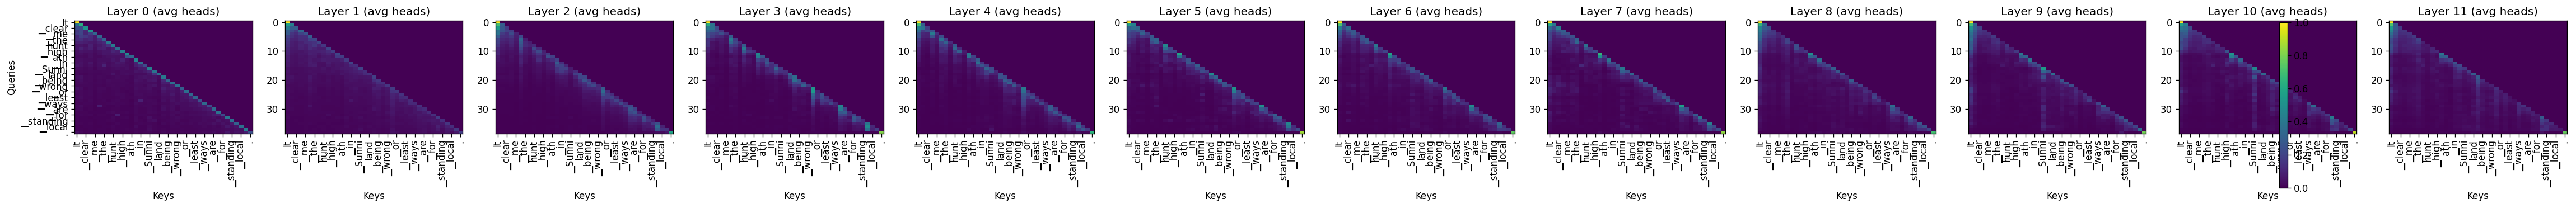

In [ ]:



#Attention across layers (avg over heads)
layers_loc = list(range(L))  # local indices 0..L-1
mats = []
qtoks = ktoks = None
for Lloc in layers_loc:
    head_mats = []
    for Hloc in range(H):
        A, q, k = fetch_attn_trim(st, eid, layer=Lloc, head=Hloc, kind="self")
        head_mats.append(A)
        if qtoks is None:
            qtoks, ktoks = tok_clean(q), tok_clean(k)
    mats.append(np.mean(np.stack(head_mats, axis=0), axis=0))

vmax = max(float(m.max()) for m in mats) if mats else 1.0

n = len(layers_loc)
fig, axes = plt.subplots(1, n, figsize=(3.2*n, 3.2), squeeze=False)
for ax, Lloc, M in zip(axes[0], layers_loc, mats):
    im = ax.imshow(M, aspect="auto", vmin=0.0, vmax=vmax)
    ax.set_title(f"Layer {dec_layer_local2actual(Lloc)} (avg heads)")
    ax.set_xlabel("Keys")
axes[0,0].set_ylabel("Queries")
fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.01)

# sparse ticks for the first panel
max_ticks = 16
nx, ny = mats[0].shape[1], mats[0].shape[0]
x_idx = list(range(0, nx, max(1, nx // max_ticks)))
y_idx = list(range(0, ny, max(1, ny // max_ticks)))
for ax in axes[0]:
    ax.set_xticks(x_idx); ax.set_xticklabels([ktoks[i] for i in x_idx], rotation=90)
axes[0,0].set_yticks(y_idx); axes[0,0].set_yticklabels([qtoks[i] for i in y_idx])
fig.tight_layout()
plt.show()


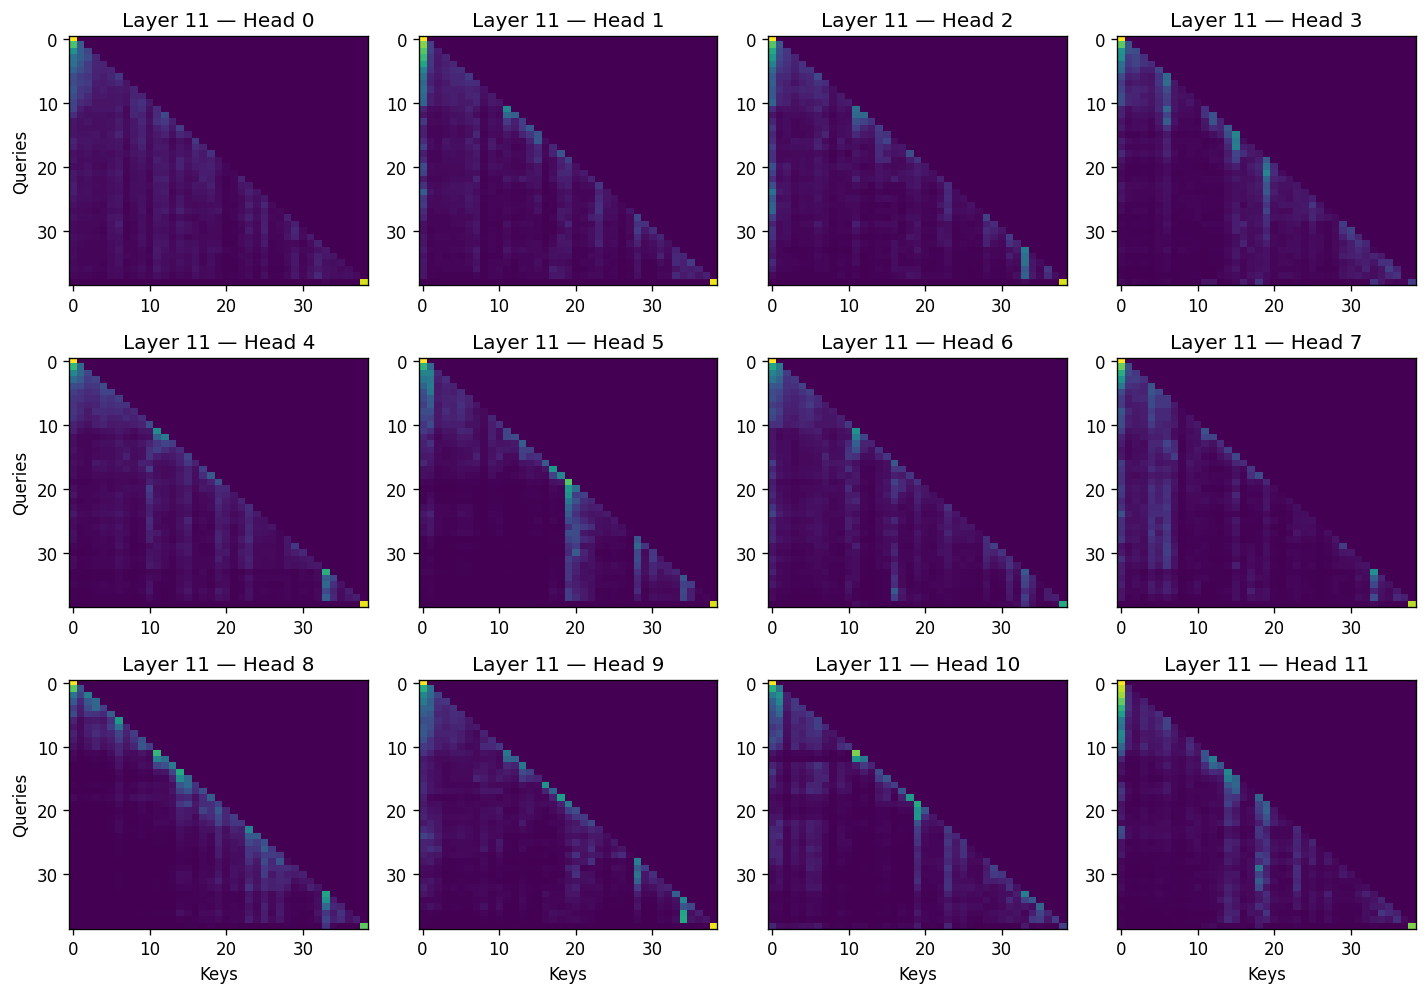

Saved GIF: notebooks_outputs\attn_across_layers_head0.gif


C:\Users\mikol\AppData\Local\Temp\ipykernel_14252\3382181223.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(); plt.show()


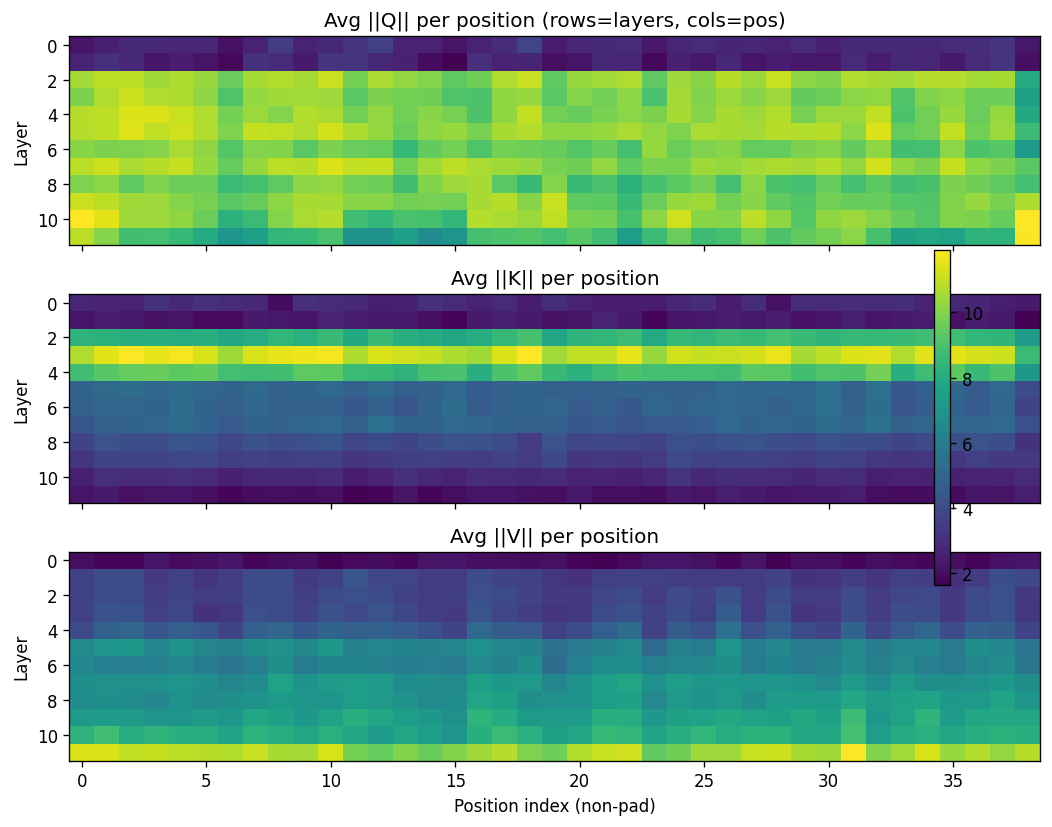

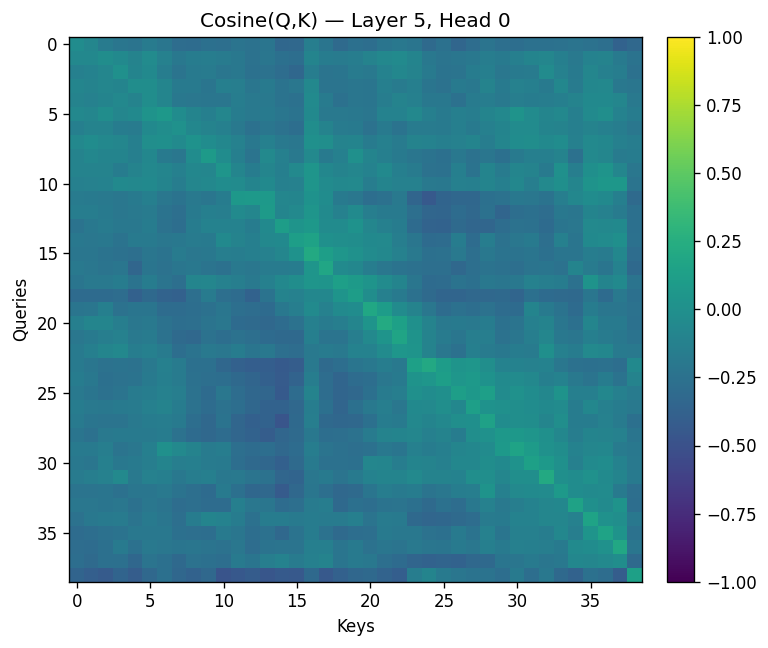

Hidden shape: (13, 128, 768)


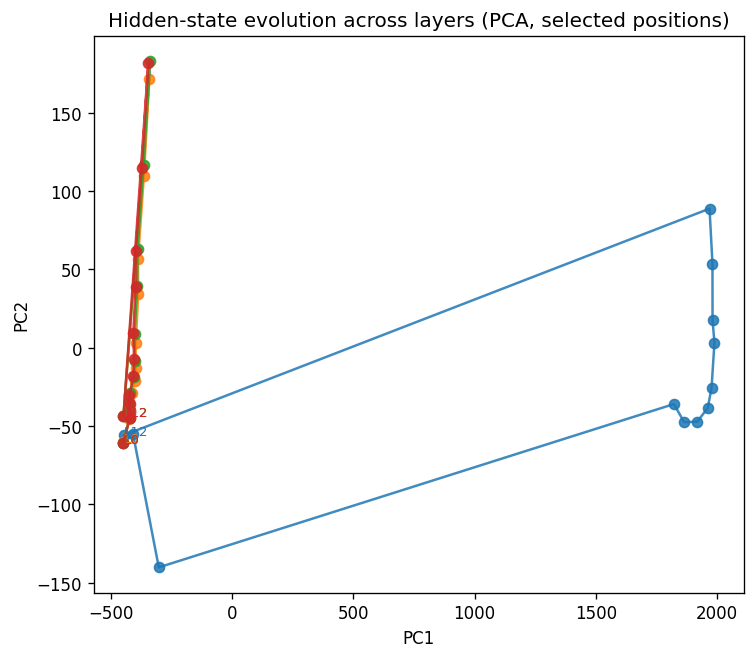

Causal mask sanity — Layer 5, Head 0
  lower-tri mean: 0.025635 upper-tri mean: 0.0
✓ Run: traces\20251006-233929_gpt2_ud_ewt_validation_n16
✓ Example: 2381d9876142e5d6 (non-pad len = 39)
✓ Visuals:
  - Across-layers attention (avg heads)
  - Heads grid at chosen layer
  - Animation across layers (inline JS; GIF saved if Pillow is present)
  - Q/K/V norms per position across layers; cosine(Q,K) heatmap
  - Hidden-state PCA (if captured)


In [ ]:
Lloc = min(L-1, 11)  # local layer index; defaults to the last (or 11)
actual_L = dec_layer_local2actual(Lloc)

H_all = list(range(H))
cols = 4
rows = math.ceil(len(H_all) / cols)

mats = []
qtoks = ktoks = None
for Hloc in H_all:
    A, q, k = fetch_attn_trim(st, eid, layer=Lloc, head=Hloc, kind="self")
    mats.append(A)
    if qtoks is None:
        qtoks, ktoks = tok_clean(q), tok_clean(k)

vmax = max(float(m.max()) for m in mats) if mats else 1.0
fig, axes = plt.subplots(rows, cols, figsize=(3.0*cols, 2.8*rows), squeeze=False)
for i, (A, Hloc) in enumerate(zip(mats, H_all)):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    ax.imshow(A, aspect="auto", vmin=0.0, vmax=vmax)
    ax.set_title(f"Layer {actual_L} — Head {dec_head_local2actual(Hloc)}")
    if r == rows-1: ax.set_xlabel("Keys")
    if c == 0:      ax.set_ylabel("Queries")
# hide extras
for j in range(len(mats), rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")
fig.tight_layout()
plt.show()

# Animate attention across layers 
head_loc = 0  # local head index to animate
frames, labels = [], []
for Lloc in range(L):
    A, q, k = fetch_attn_trim(st, eid, layer=Lloc, head=head_loc, kind="self")
    frames.append(A)
    labels.append(f"L{dec_layer_local2actual(Lloc)}")

vmax = max(float(f.max()) for f in frames) if frames else 1.0
qt, kt = tok_clean(q), tok_clean(k)

fig, ax = plt.subplots(figsize=(6.2, 5.2))
im = ax.imshow(frames[0], aspect="auto", vmin=0.0, vmax=vmax)
ttl = ax.set_title(f"Decoder Self-Attn — Head {dec_head_local2actual(head_loc)} — {labels[0]}")
ax.set_xlabel("Keys"); ax.set_ylabel("Queries")
max_ticks = 30
nx, ny = frames[0].shape[1], frames[0].shape[0]
x_idx = list(range(0, nx, max(1, nx // max_ticks)))
y_idx = list(range(0, ny, max(1, ny // max_ticks)))
ax.set_xticks(x_idx); ax.set_xticklabels([kt[i] for i in x_idx], rotation=90)
ax.set_yticks(y_idx); ax.set_yticklabels([qt[i] for i in y_idx])
plt.tight_layout()

def _update(i):
    im.set_data(frames[i])
    ttl.set_text(f"Decoder Self-Attn — Head {dec_head_local2actual(head_loc)} — {labels[i]}")
    return [im, ttl]

ani = animation.FuncAnimation(fig, _update, frames=len(frames), interval=700, blit=False)

display(HTML(ani.to_jshtml()))

gif_path = OUT_DIR / f"attn_across_layers_head{dec_head_local2actual(head_loc)}.gif"
try:
    ani.save(gif_path.as_posix(), writer="pillow", fps=1)
    print("Saved GIF:", gif_path)
except Exception as e:
    print("GIF save skipped (need Pillow):", e)
plt.close(fig)


#Q / K / V diagnostics
Ld = int(attn_mask.sum())
q_norms = np.zeros((L, Ld), dtype=np.float32)
k_norms = np.zeros((L, Ld), dtype=np.float32)
v_norms = np.zeros((L, Ld), dtype=np.float32)

for Lloc in range(L):
    qh = []; kh = []; vh = []
    for Hloc in range(H):
        Q, K, V = fetch_qkv_trim(st, eid, layer=Lloc, head=Hloc)
        qh.append(np.linalg.norm(Q, axis=-1))
        kh.append(np.linalg.norm(K, axis=-1))
        vh.append(np.linalg.norm(V, axis=-1))
    q_norms[Lloc] = np.mean(np.stack(qh, 0), 0)
    k_norms[Lloc] = np.mean(np.stack(kh, 0), 0)
    v_norms[Lloc] = np.mean(np.stack(vh, 0), 0)

fig, axs = plt.subplots(3, 1, figsize=(9, 7), sharex=True)
axs[0].imshow(q_norms, aspect="auto"); axs[0].set_title("Avg ||Q|| per position (rows=layers, cols=pos)")
axs[1].imshow(k_norms, aspect="auto"); axs[1].set_title("Avg ||K|| per position")
im = axs[2].imshow(v_norms, aspect="auto"); axs[2].set_title("Avg ||V|| per position")
axs[-1].set_xlabel("Position index (non-pad)")
for i, ax in enumerate(axs): ax.set_ylabel("Layer")
fig.colorbar(im, ax=axs, fraction=0.02, pad=0.01)
fig.tight_layout(); plt.show()

# Cosine(Q,K) at one layer/head
from numpy.linalg import norm
Lloc = min(L-1, 5)
Hloc = 0
actual_L = dec_layer_local2actual(Lloc); actual_H = dec_head_local2actual(Hloc)
Q, K, V = fetch_qkv_trim(st, eid, layer=Lloc, head=Hloc)
Qn = Q / (norm(Q, axis=-1, keepdims=True) + 1e-8)
Kn = K / (norm(K, axis=-1, keepdims=True) + 1e-8)
QK_cos = Qn @ Kn.T
plt.figure(figsize=(6.5,5.5))
plt.imshow(QK_cos, aspect="auto", vmin=-1.0, vmax=1.0)
plt.title(f"Cosine(Q,K) — Layer {actual_L}, Head {actual_H}")
plt.xlabel("Keys"); plt.ylabel("Queries")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


# Hidden-state PCA 
arrays = st.arrays()
has_hidden = any(k.endswith("hidden.zarr") or k=="hidden" or "hidden" in k for k in arrays.keys())

if has_hidden:
    try:
        Hs = st.hidden(eid, side="dec")  # (L+1, T, D)
        print("Hidden shape:", Hs.shape)
        Ld = int(attn_mask.sum())
        Hs = Hs[:, :Ld, :]

        from sklearn.decomposition import PCA
        pos_idx = [0, max(1, Ld//3), max(2, (2*Ld)//3), Ld-1]
        colors = ["tab:blue","tab:orange","tab:green","tab:red"]

        X = np.concatenate([Hs[:, i, :] for i in pos_idx], axis=0)
        pca = PCA(n_components=2, random_state=0).fit(X)

        plt.figure(figsize=(6.4,5.6))
        for p, c in zip(pos_idx, colors):
            Xp = pca.transform(Hs[:, p, :])
            plt.plot(Xp[:,0], Xp[:,1], marker="o", color=c, alpha=0.85)
            # label first and last layer points
            plt.text(Xp[0,0], Xp[0,1], "L0", fontsize=8, color=c)
            plt.text(Xp[-1,0], Xp[-1,1], f"L{Hs.shape[0]-1}", fontsize=8, color=c)
        plt.title("Hidden-state evolution across layers (PCA, selected positions)")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Hidden present but could not be visualized:", e)
else:
    print("No hidden states captured (skip PCA). Re-extract with `--capture hidden` to enable.")


# Causal sanity: lower vs upper triangle mean
Lcheck = min(L-1, 5)
Hcheck = 0
A, q, k = fetch_attn_trim(st, eid, layer=Lcheck, head=Hcheck, kind="self")
lower_mean = float(np.tril(A, 0).mean())
upper_mean = float(np.triu(A, 1).mean())
print(f"Causal mask sanity — Layer {dec_layer_local2actual(Lcheck)}, Head {dec_head_local2actual(Hcheck)}")
print("  lower-tri mean:", round(lower_mean, 6), "upper-tri mean:", round(upper_mean, 6))


# Summary
print(" Run:", run_dir)
print(" Example:", eid, f"(non-pad len = {int(attn_mask.sum())})")
print(" Visuals:")
print(" - Across-layers attention (avg heads)")
print(" - Heads grid at chosen layer")
print(" - Animation across layers (inline JS; GIF saved if Pillow is present)")
print(" - Q/K/V norms per position across layers; cosine(Q,K) heatmap")
print(" - Hidden-state PCA (if captured)")


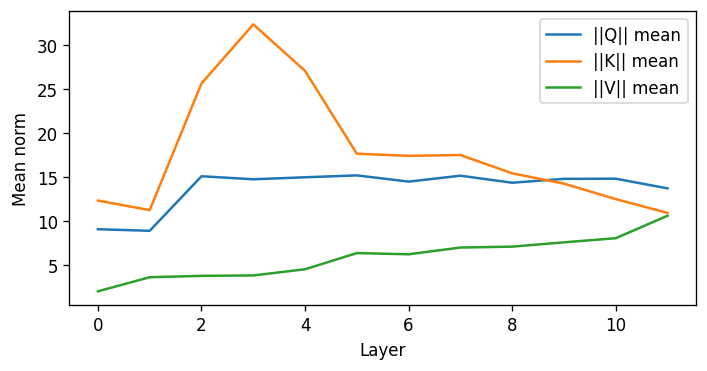

In [15]:
# Per-layer means of ||Q||, ||K||, ||V||
q_mean_L = q_norms.mean(axis=1)
k_mean_L = k_norms.mean(axis=1)
v_mean_L = v_norms.mean(axis=1)

plt.figure(figsize=(6,3.2))
plt.plot(q_mean_L, label="||Q|| mean")
plt.plot(k_mean_L, label="||K|| mean")
plt.plot(v_mean_L, label="||V|| mean")
plt.xlabel("Layer"); plt.ylabel("Mean norm")
plt.legend(); plt.tight_layout(); plt.show()


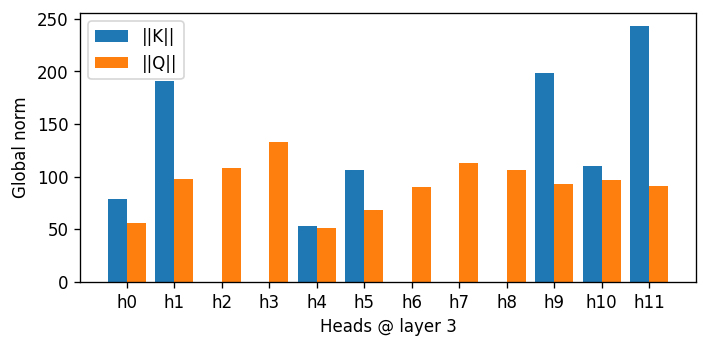

In [10]:
Lloc = int(np.argmax(k_mean_L))  # layer with highest ||K||
per_head = []
for Hloc in range(H):
    Q,K,V = fetch_qkv_trim(st, eid, layer=Lloc, head=Hloc)
    per_head.append([np.linalg.norm(Q).item(), np.linalg.norm(K).item(), np.linalg.norm(V).item()])
per_head = np.array(per_head)  # (H, 3)

plt.figure(figsize=(6,3))
plt.bar(np.arange(H)-0.2, per_head[:,1], width=0.4, label="||K||")
plt.bar(np.arange(H)+0.2, per_head[:,0], width=0.4, label="||Q||")
plt.xticks(range(H), [f"h{h}" for h in range(H)]); plt.xlabel(f"Heads @ layer {Lloc}")
plt.ylabel("Global norm"); plt.legend(); plt.tight_layout(); plt.show()



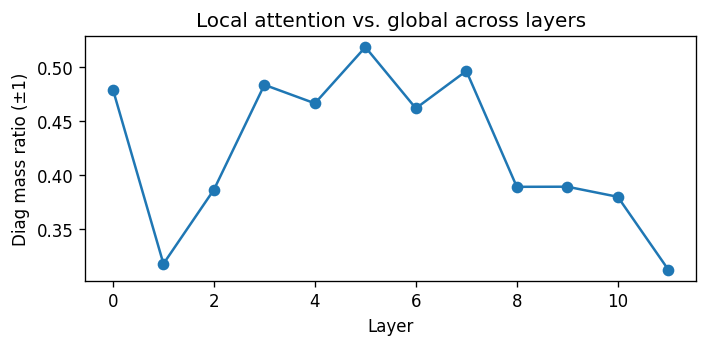

In [11]:
def diag_ratio(A, w=1):
    # mass in diagonal band ±w vs total
    mask = np.zeros_like(A, dtype=bool)
    for i in range(A.shape[0]):
        j0, j1 = max(0, i-w), min(A.shape[1], i+w+1)
        mask[i, j0:j1] = True
    d = A[mask].sum(); t = A.sum() + 1e-12
    return (d / t).item()

ratios = []
for Lloc in range(L):
    vals = []
    for Hloc in range(H):
        A,_,_ = fetch_attn_trim(st, eid, layer=Lloc, head=Hloc)
        vals.append(diag_ratio(A, w=1))
    ratios.append(np.mean(vals))
plt.figure(figsize=(6,3))
plt.plot(ratios, marker="o")
plt.xlabel("Layer"); plt.ylabel("Diag mass ratio (±1)")
plt.title("Local attention vs. global across layers")
plt.tight_layout(); plt.show()
